In [1]:
%load_ext autoreload
%autoreload

import json
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import tqdm
import random
import torch
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertForMaskedLM, BertConfig
from transformers import XLMTokenizer, XLMModel, XLMConfig

from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC
import inlp, inlp_dataset_handler, inlp_linear_model
import copy
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import pandas as pd
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv

In [ ]:
with open('tweets.above-100.no-retweets.no-http.txt', "r", encoding = "utf-8") as f:
  lines = f.readlines()

all_data = []

for line in tqdm_notebook(lines[:]):
    d = eval(line) #json.loads(line)
    text = d["text"]
    lang = d["lang"]
    all_data.append({"text": text.replace("\n", "."), "lang": lang})

### Load parallal TED dataset

In [2]:
import pandas as pd
df = pd.read_csv("all_talks_train.tsv", sep = "\t")
df = df[df["en"].str.len() > 75]
df = df.dropna()
del df["talk_name"]
#df = df.rename(columns=lambda x: x.replace('pt-br', 'pt').replace("zh-cn", "zh"))
#df.rename(columns={'pt-br': 'pt', 'zh-cn': 'zh'}, inplace=True)
df.head(5)
all_langs = ".".join(list(df.columns.values)).split(".")
all_data = []

for lang in all_langs:
    relevant = list(df[lang].values)              
    #lang = lang.replace("zh-cn", "zh").replace("pt-br", "pt")
    
    for sent in relevant:
        if "NULL" not in sent:
            all_data.append({"text": sent.replace("\n", ".").replace("&apos; ", "'").replace(" &apos; ", "'").replace("&apos;", "'").replace("&quot;", '"'), "lang": lang})



In [4]:
set([d["lang"] for d in all_data])

{'ar',
 'az',
 'be',
 'bg',
 'bn',
 'bs',
 'cs',
 'da',
 'de',
 'el',
 'en',
 'eo',
 'es',
 'et',
 'eu',
 'fa',
 'fi',
 'fr',
 'fr-ca',
 'gl',
 'he',
 'hi',
 'hr',
 'hu',
 'hy',
 'id',
 'it',
 'ja',
 'ka',
 'kk',
 'ko',
 'ku',
 'lt',
 'mk',
 'mn',
 'mr',
 'ms',
 'my',
 'nb',
 'nl',
 'pl',
 'pt',
 'pt-br',
 'ro',
 'ru',
 'sk',
 'sl',
 'sq',
 'sr',
 'sv',
 'ta',
 'th',
 'tr',
 'uk',
 'ur',
 'vi',
 'zh',
 'zh-cn',
 'zh-tw'}

In [5]:
langs = ["zh-tw", "zh-cn", "pt-br", "en", "ar", "he", "ru", "ko", "it", "ja", "es", "fr", "nl", "ro", "tr"]

In [6]:
[d for d in all_data if d["lang"] == "fr"]

[{'text': "Parmi tous les déficits inquiétants contre lesquels nous luttons aujourd'hui — surtout en matière économique et financière — celui qui me préoccupe le plus est le déficit du dialogue politique — notre capacité à résoudre les conflits modernes tels qu'ils sont , d'aller à la source de ce qu'ils sont et d'identifier les principaux acteurs et de traiter avec eux .",
  'lang': 'fr'},
 {'text': 'Nous qui sommes des diplomates , sommes formés pour gérer les conflits entre les Etats et les questions entre les Etats .',
  'lang': 'fr'},
 {'text': "Mais la situation évolue , et nous constatons qu'il y a de nouveaux acteurs clés qui arrivent sur la scène .",
  'lang': 'fr'},
 {'text': 'Nous les appelons vaguement « groupes » . Ils peuvent représenter des réalités sociales , religieuses , politiques , économiques , ou militaires .',
  'lang': 'fr'},
 {'text': "Les règles d'engagement : comment dialoguer , quand dialoguer , et comment traiter avec eux .",
  'lang': 'fr'},
 {'text': "Per

In [8]:

data = []
n = 10000

#langs = ["en", "ar", "es", "pt", "it", "fr", "in", "hi", "de", "ru", "nl", "ja", "th", "tl"]
#langs = ["en", "es", "it", "pt", "ru", "hi", "de", "fr", "ar", "iw", "nl", "fa", "ur", "pl", "th", "ro", "sv", "ta", "ja", "ko"]
for lang in langs:    
    print(lang)
    lang_data = [d for d in all_data if d["lang"] == lang]

    for i in range(n):
        tweet = random.choice(lang_data)
        data.append({"lang": lang, "text": tweet["text"]})



zh-tw
zh-cn
pt-br
en
ar
he
ru
ko
it
ja
es
fr
nl
ro
tr


In [10]:
data[3], len(data)

({'lang': 'zh-tw', 'text': '當然 , 現在我和我們所有人 ， 對我們生活的重大決策 都有很多自主權 。'}, 150000)

In [11]:
from collections import Counter
all_langs_data = [d["lang"] for d in all_data]
counter = Counter(all_langs_data)
print(counter.most_common(100))

[('en', 143855), ('ar', 118593), ('he', 116799), ('ru', 114324), ('ko', 112382), ('it', 112090), ('ja', 111700), ('zh-tw', 110225), ('zh-cn', 108744), ('es', 105818), ('fr', 103601), ('tr', 99313), ('pt-br', 98664), ('nl', 98293), ('ro', 98175), ('bg', 95888), ('pl', 95608), ('vi', 93708), ('de', 89798), ('fa', 83056), ('hu', 80107), ('sr', 73599), ('el', 71440), ('hr', 66600), ('uk', 59270), ('cs', 55246), ('th', 53921), ('id', 46238), ('sk', 32751), ('sv', 28460), ('da', 24124), ('pt', 23747), ('sq', 23644), ('lt', 22238), ('mk', 13867), ('fi', 12658), ('my', 11399), ('hy', 11105), ('sl', 10543), ('fr-ca', 10342), ('hi', 9858), ('nb', 8326), ('ka', 6700), ('ku', 5868), ('et', 5711), ('gl', 5168), ('mr', 4870), ('mn', 3639), ('ur', 3184), ('eo', 3166), ('ta', 3149), ('az', 3126), ('bs', 2946), ('eu', 2755), ('ms', 2689), ('bn', 2564), ('zh', 2397), ('be', 2383), ('kk', 1709)]


## Run BERT

In [12]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu', model = "bert"):

        if model == "bert":
            config = BertConfig.from_pretrained("bert-base-multilingual-uncased", output_hidden_states=True)
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
            self.model = BertForMaskedLM.from_pretrained('bert-base-multilingual-uncased', config = config)
        
        elif model == "hila-mbert":
            self.tokenizer = BertTokenizer.from_pretrained('/home/nlp/gonenhi/mbert/models/model1_epoch3')
            self.model = BertForSequenceClassification.from_pretrained('/home/nlp/gonenhi/mbert/models/model1_epoch3', num_labels = 3,
                                                      output_attentions = True, output_hidden_states = True)
        
        elif model == "xlm":
            config = XLMConfig.from_pretrained("xlm-mlm-100-1280", output_hidden_states=True)
            self.tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
            self.model = XLMModel.from_pretrained("xlm-mlm-100-1280", config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str]) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """
        
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        tokenized_text = tokenized_text[:512]
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            if type(self.model) == BertModel:
                predictions = torch.cat([outputs[2][l] for l in layers], axis = 2)#.detach().cpu().numpy()
            else: #xlm
                predictions = torch.cat([outputs[1][l] for l in layers], axis = 2)#.detach().cpu().numpy()
            
            if layers[0] == 12:
                cls = self.model.cls.predictions.transform
                predictions = cls(predictions)
            
            predictions = predictions.detach().cpu().numpy()
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok, tokenized_text)
        
        
EXCLUDE = set([",", '"', ".", " ", "«", "»", "?", "!", "'", ":", ";", "#", "@", "$", "¿", "¡", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", ":", "0"])
for i in range(3000):
 EXCLUDE.add(str(i))

def collect_bert_states(bert, data: List[Tuple], layers: List[int], strategy = "mean"):
        
        for i,d in tqdm.tqdm_notebook(enumerate(data), total = len(data)):

            sent = d["text"]
            preds, orig2tok, bert_tokens = bert.encode(sent, layers = layers)
            if strategy == "sum":
                exclude = [orig2tok[i] for i in orig2tok.keys() if bert_tokens[orig2tok[i]] not in EXCLUDE]
                keep = [i for i in range(len(preds)) if i not in exclude]
                states = np.sum(preds[keep], axis = 0)
                
            elif strategy == "cls":
                states = preds[0]
            elif strategy == "rand-word":
                ind = 0
                states = None
                while ind < 75:
                    rand_word_index = random.choice(list(orig2tok.keys()))
                    if orig2tok[rand_word_index] > len(preds): continue
                    tok = bert_tokens[orig2tok[rand_word_index]]
                    if tok not in EXCLUDE:
                        states = preds[orig2tok[rand_word_index]]
                        break
                    ind += 1
                if states is None:
                    states = np.zeros_like(preds[0])
            data[i]["vec"] = states
    
        return data

In [13]:
bert = BertEncoder(device = "cuda", model = "bert")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/shauli/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token

In [98]:
random.shuffle(all_data)
random.shuffle(data)

data_with_states = collect_bert_states(bert, copy.deepcopy(data)[:5000], layers = [0], strategy = "rand-word")

/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:104: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## TSNE by language (Before INLP)

In [32]:
COLORS = [np.random.rand(1,3) for i in range(100)]

In [109]:

def tsne(vecs, labels, title="", ind2label = None, annotate = True, metric = "l2", color_gradient = False):
  

  tsne = TSNE(n_components=2, random_state=1, metric = metric, perplexity = 32)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  fig, ax = plt.subplots()
    
  for i, c, label in zip(sorted(set(labels.tolist())), COLORS, names):
        plt.scatter(vecs_2d[labels == label, 0], vecs_2d[labels == label, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
  #plt.legend(prop={'size': 9})
  plt.title(title)
    
  if annotate:

      for i, label in enumerate(names):
        relevant = vecs_2d[labels == label, :]
        mean_x, mean_y = np.median(relevant, axis = 0)
        ax.annotate(label, (mean_x, mean_y), fontsize = 18, weight = "bold")

  plt.tight_layout()
  plt.savefig("embeddings.nullspace.pdf", dpi = 400)
  plt.show()

In [100]:
random.shuffle(data_with_states)
vecs = np.array([d["vec"] for d in data_with_states][:])
labels_lang = np.array([d["lang"] for d in data_with_states][:])

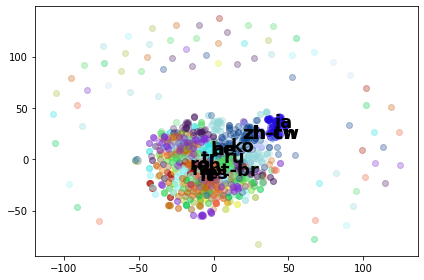

In [101]:

tsne(vecs[:1500], labels_lang[:1500])

In [103]:
#p = np.load("paper/INLP_matrices/P_nullspace_rand_token_in_context_15lang_20iter_5000perlang.npy") # layer 14 (after layernorm)
p = np.load("paper/INLP_matrices/P_nullspace_rand_token_in_context_15lang_20iter_5000perlang_embeddings.npy") #embeddings
p_rowspace = np.eye(768) - p

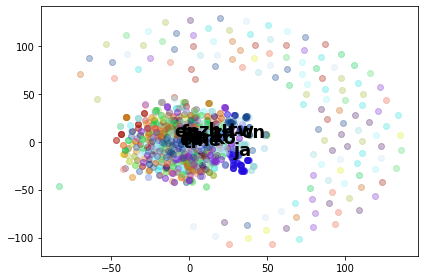

In [110]:
tsne(vecs[:1500].dot(p), labels_lang[:1500])

In [126]:
def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

print("v measure original: ", compute_v_measure(vecs[:3500], labels_lang[:3500], k=len(langs)))
print("v measure nullsapce: ", compute_v_measure(vecs[:3500].dot(p), labels_lang[:3500], k=len(langs)))
print("v measure rowspace: ", compute_v_measure(vecs[:3500].dot(p_rowspace), labels_lang[:3500], k=len(langs)))


v measure original:  0.8054038456932316
v measure nullsapce:  0.11447809710121253
v measure rowspace:  0.9035296977135137


## Classify language

In [204]:
l = int(len(vecs) * 0.9)
x_train_cls, x_dev_cls = vecs[:l], vecs[l:]
y_train_cls, y_dev_cls = labels_lang[:l], labels_lang[l:]
model = SGDClassifier(max_iter = 1000, alpha = 0.01)
model.fit(x_train_cls, y_train_cls)
print(model.score(x_dev_cls, y_dev_cls))

0.9913333333333333


## Create dataset for INLP

In [205]:
num_examples_per_language = 2000
vecs1, vecs2, labels = [], [], []
for lang in langs:
    relevant = [d for d in data_with_states if d["lang"] == lang]
    rest = [d for d in data_with_states if d["lang"] != lang]
    for i in range(num_examples_per_language):
        positive_pair = random.choice(relevant)["vec"], random.choice(relevant)["vec"]
        negative_pair = random.choice(relevant)["vec"], random.choice(rest)["vec"]
        
        # positive
        
        vecs1.append(positive_pair[0])
        vecs2.append(positive_pair[1])
        labels.append(1)
        
        # negative 
        vecs1.append(negative_pair[0])
        vecs2.append(negative_pair[1])
        labels.append(0)

vecs1, vecs2, labels = sklearn.utils.shuffle(vecs1, vecs2, labels)
vecs1 = np.array(vecs1)
vecs2 = np.array(vecs2)
labels = np.array(labels)
print(vecs1.shape, vecs2.shape, labels.shape)
l = int(len(vecs1) * 0.9)
x_train1, x_dev1 = vecs1[:l], vecs1[l:]
x_train2, x_dev2 = vecs2[:l], vecs2[l:]
y_train, y_dev = labels[:l], labels[l:]

"""
concat_train = np.concatenate([x_train1, x_train2], axis = 1)
concat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(concat_train, y_train)
print(model.score(concat_dev, y_dev))
"""

(56000, 1280) (56000, 1280) (56000,)


'\nconcat_train = np.concatenate([x_train1, x_train2], axis = 1)\nconcat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)\nmodel = SGDClassifier(max_iter = 1000, alpha = 0.1)\nmodel.fit(concat_train, y_train)\nprint(model.score(concat_dev, y_dev))\n'

## Siamese INLP

In [ ]:
inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 20, "input_dim": 768, "hidden_dim": 16, "batch_size": 16, "verbose": False, "device": "cpu",
         "compare_by": "dot_product", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = False)

### Try several different INLP dimensions

In [ ]:
for num_classifiers in [10]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(vecs.T).T[:2000], labels_lang[:2000])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
x_train_cls_pca = pca.fit_transform(x_train_cls)
x_dev_cls_pca = pca.transform(x_dev_cls)

print(x_train_cls_pca.shape, x_dev_cls_pca.shape)

## Classification INLP

In [206]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train_cls, y_train_cls, x_dev_cls, y_dev_cls, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"loss": "hinge", "fit_intercept": False, "max_iter": 10000, "alpha": 0.05, "n_iter_no_change": 10})

# Try several different INLP dimensions


iteration: 4, accuracy: 0.25133333333333335: 100%|██████████| 5/5 [01:21<00:00, 16.34s/it]


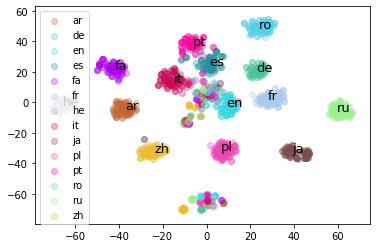

In [207]:
for num_classifiers in [5]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 1280, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(x_dev_cls.T).T[:1500], y_dev_cls[:1500])

In [110]:
labels_lang.shape, x_dev_cls.shape

((10000,), (1000, 768))

In [111]:
np.save("P_rowspace.50k.rand-word.layer=0.bert-cased-xnli-classifier-before-finetuning.npy", P_rowspace)
np.save("P.50k.rand-word.layer=0.bert-cased-xnli-classifier-before-finetuning.npy", P)

In [208]:
print(P[0][:5], P_rowspace[0][:5])

[ 0.94885105 -0.0026605  -0.00858441  0.00817527 -0.00114074] [ 0.05114895  0.0026605   0.00858441 -0.00817527  0.00114074]


In [209]:
model = SGDClassifier(max_iter = 1000, alpha = 0.01)
model.fit(P_rowspace.dot(x_train_cls.T).T, y_train_cls)
print(model.score(P_rowspace.dot(x_dev_cls.T).T, y_dev_cls))

0.994


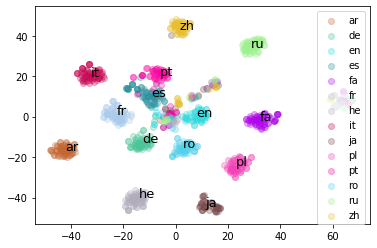

In [210]:
concat = np.concatenate(Ws, axis = 0)
P_rowspace_concat = inlp.get_rowspace_projection(concat)
tsne(P_rowspace_concat.dot(vecs.T).T[:1000], labels_lang[:1000])

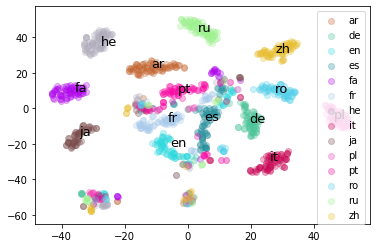

In [211]:
vecs_projected_low_dim = []
for w in Ws:
    w_normalized = w / np.linalg.norm(w, axis = 1, keepdims = True)
    w_projection = w_normalized.dot(vecs.T).T
    vecs_projected_low_dim.append(w_projection)

vecs_projected_low_dim = np.concatenate(vecs_projected_low_dim, axis = 1)
tsne(vecs_projected_low_dim[:1200], labels_lang[:1200])

In [212]:
concat_normalized = concat / np.linalg.norm(concat, axis = 1, keepdims = True)
vecs_projected_low_dim2 = concat_normalized.dot(vecs.T).T
vecs_projected_low_dim2[0][:5], vecs_projected_low_dim[0][:5]

(array([-2.06639368, -1.90114237, -3.14985425, -1.84860126, -1.75054069]),
 array([-2.06639368, -1.90114237, -3.14985425, -1.84860126, -1.75054069]))

In [213]:
x_train_cls[0][:10]

array([ 0.7703344 , -1.6334279 ,  0.21665926,  0.76713747,  0.24026653,
        0.93452734,  0.47969562, -1.1849086 , -0.7864693 , -1.2931107 ],
      dtype=float32)

### Draw a dendrogram

In [250]:
lang_vecs = {}
for lang in langs:
       relevant = [d for d in data_with_states if d["lang"] == lang]
       vecs_relevant = np.array([d["vec"] for d in relevant])
       #vecs_relevant = P_rowspace.dot(vecs_relevant.T).T
       #vecs_relevant = concat_normalized.dot(vecs_relevant.T).T
       #vecs_relevant = P.dot(vecs_relevant.T).T
       lang_vecs[lang] = np.mean(vecs_relevant, axis = 0)

In [251]:
vecs_relevant.shape

(2150, 1280)

In [252]:
vecs_for_all_languages = [lang_vecs[lang] for lang in langs]

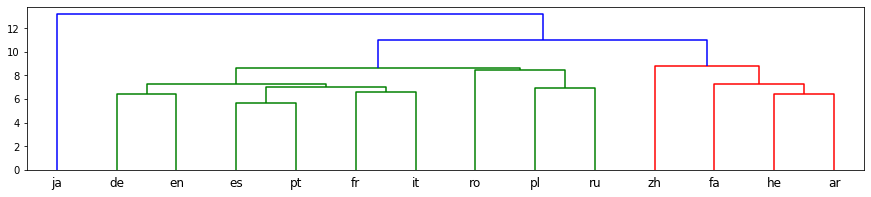

In [253]:
linked = linkage(vecs_for_all_languages, 'ward', optimal_ordering = True)
plt.figure(figsize=(15, 3))
dendrogram(
            linked,
            orientation='top',
            labels=langs,
            distance_sort='descending',
            show_leaf_counts=False,
            leaf_rotation = 0
          )
plt.show()

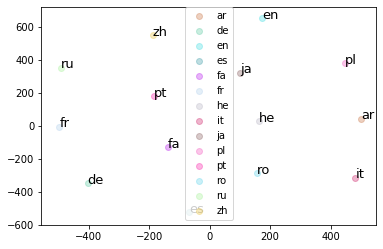

In [240]:
tsne(np.array(list(lang_vecs.values())), np.array(list(lang_vecs.keys())))

### Do word vectors cluster by canonical word order?

In [241]:
SVO = {"en", "ru"}
SOV = {"de", "nl"}
data_for_word_order = []

for word_order_group, word_order in zip([SVO, SOV], ["SVO", "SOV"]):
    for lang in word_order_group:
        print(lang)
        relevant = [d for d in data_with_states if d["lang"] == lang]
        vecs_relevant = np.array([d["vec"] for d in relevant])
        vecs_relevant = concat_normalized.dot(vecs_relevant.T).T
        for v in vecs_relevant:
            data_for_word_order.append((v, word_order))
                predictions = outputs[2][0].detach().cpu().numpy()

IndentationError: unexpected indent (<ipython-input-241-1eea0306456f>, line 13)

In [ ]:
random.shuffle(data_for_word_order)
vecs_word_ordr, labels_word_order = map(np.array, zip(*data_for_word_order))

In [ ]:
tsne(vecs_word_ordr[:1000], labels_word_order[:1000])

## CCA analysis

In [219]:
import lang2vec.lang2vec as l2v
vecs_and_headers = [l2v.get_features(lang, "syntax_wals", header=True) for lang in langs]
headers = vecs_and_headers[0]["CODE"]
lang_codes = [list(d.keys())[1] for d in vecs_and_headers]
lang2vecs_vecs = np.array([[int(y) if y != "--" else -1000 for y in x[lang] ] for x,lang in zip(vecs_and_headers, lang_codes)])
our_lang_vecs = np.array([lang_vecs[lang] for lang in langs])
our_lang_vecs = np.random.rand(*our_lang_vecs.shape)

### find interseting propeties

In [220]:
feature2proportion = {}
# TODO: CHECK LOGIC
for i, typ_feature in enumerate(headers):
    counts = []
    for lang in langs:
        k = lang_codes.index(lang)
        if int(lang2vecs_vecs[k][i]) == 1:
            counts.append(1)
        else:
            counts.append(0)
        
    feature2proportion[typ_feature] = sum(counts) / len(counts)

items = feature2proportion.items()
sorted_items = sorted(items, key = lambda feature_and_prop: abs(feature_and_prop[1] - 0.5))
k = 5
top_features, props = zip(*(sorted_items[:k]))
for feature in top_features:
    print(feature)
    for lang in langs:
        k = lang_codes.index(lang)
        i = headers.index(feature)
        print(lang, lang2vecs_vecs[k][i])
    print("===============================")

S_GENDER_MARK
en 1
fr 1
it -1000
ro -1000
ru 1
pl -1000
de 1
es 1
pt -1000
ar 1
he 1
zh 0
fa 0
ja -1000
S_SEX_MARK
en 1
fr 1
it -1000
ro -1000
ru 1
pl -1000
de 1
es 1
pt -1000
ar 1
he 1
zh 0
fa 0
ja -1000
S_ADJECTIVE_AFTER_NOUN
en 0
fr 1
it 1
ro 1
ru 0
pl 0
de 0
es 1
pt 1
ar 1
he 1
zh 0
fa 1
ja 0
S_OBJECT_DEPMARK
en 1
fr 0
it -1000
ro -1000
ru 1
pl -1000
de 1
es 1
pt -1000
ar 0
he 1
zh 1
fa 1
ja 1
S_POSSESSIVE_DEPMARK
en 1
fr 1
it -1000
ro -1000
ru 1
pl -1000
de 1
es 1
pt -1000
ar 0
he 1
zh 1
fa 0
ja 1


In [223]:
propeties_to_check = ["S_ARTICLE_WORD_AFTER_NOUN", "S_DEGREE_WORD_AFTER_ADJECTIVE", "S_NEGATIVE_WORD_ADJACENT_AFTER_VERB", "S_DEMONSTRATIVE_WORD_AFTER_NOUN", "S_ADJECTIVE_BEFORE_NOUN", "S_COMPLEMENTIZER_WORD_AFTER_CLAUSE", "S_POSSESSOR_AFTER_NOUN", "S_NEGATIVE_WORD_AFTER_VERB", "S_NUMERAL_AFTER_NOUN", "S_NEGATIVE_WORD_BEFORE_VERB", "S_ADPOSITION_BEFORE_NOUN", "S_RELATIVE_BEFORE_NOUN"]

S_ARTICLE_WORD_AFTER_NOUN


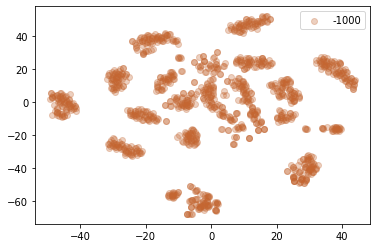

S_DEGREE_WORD_AFTER_ADJECTIVE


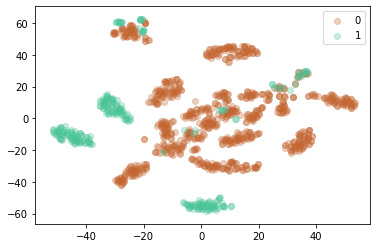

S_NEGATIVE_WORD_ADJACENT_AFTER_VERB


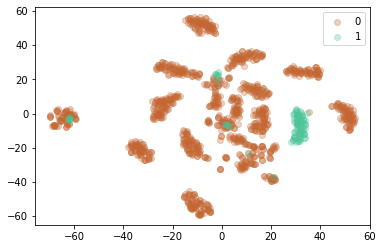

S_DEMONSTRATIVE_WORD_AFTER_NOUN


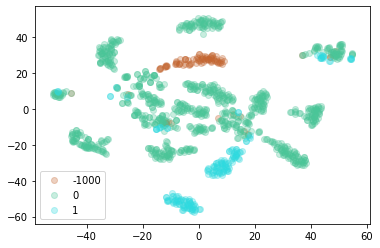

S_ADJECTIVE_BEFORE_NOUN


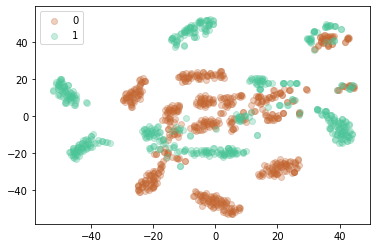

S_COMPLEMENTIZER_WORD_AFTER_CLAUSE


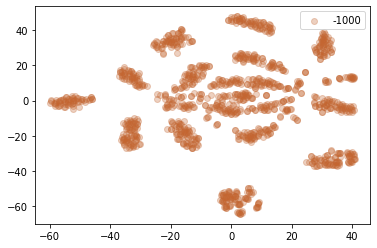

S_POSSESSOR_AFTER_NOUN


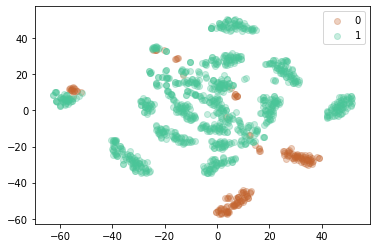

S_NEGATIVE_WORD_AFTER_VERB


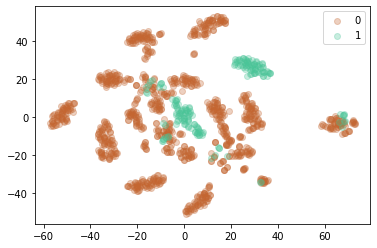

S_NUMERAL_AFTER_NOUN


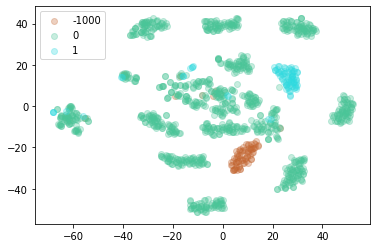

S_NEGATIVE_WORD_BEFORE_VERB


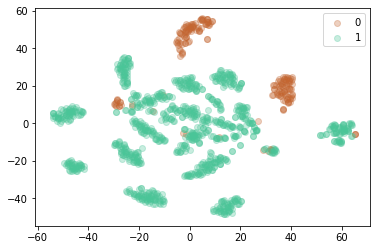

S_ADPOSITION_BEFORE_NOUN


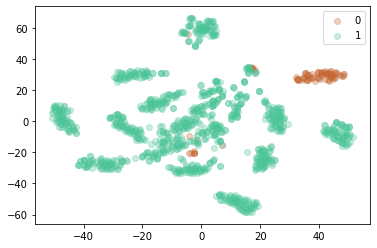

S_RELATIVE_BEFORE_NOUN


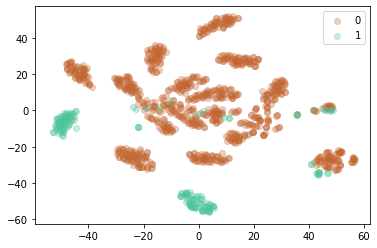

In [224]:

for prop in propeties_to_check:
    
    vevs_for_typo, lang_labels_for_typo, property_annotation_for_typo = [], [], []

    
    property_index = headers.index(prop)
    for lang in langs:
        relevant = [d for d in data_with_states if d["lang"] == lang]
        vecs_relevant = np.array([d["vec"] for d in relevant])
        vecs_relevant = concat_normalized.dot(vecs_relevant.T).T
        k = lang_codes.index(lang)
        prop_is_in_lang = lang2vecs_vecs[k][property_index]
        for v in vecs_relevant:
            vevs_for_typo.append(v)
            lang_labels_for_typo.append(lang)
            property_annotation_for_typo.append(prop_is_in_lang)

    vevs_for_typo = np.array(vevs_for_typo)
    lang_labels_for_typo = np.array(lang_labels_for_typo)
    property_annotation_for_typo = np.array(property_annotation_for_typo)
    vevs_for_typo, lang_labels_for_typo, property_annotation_for_typo = sklearn.utils.shuffle(vevs_for_typo, lang_labels_for_typo, property_annotation_for_typo)
    print(prop)
    tsne(vevs_for_typo[:1200], property_annotation_for_typo[:1200], annotate = False)
    #tsne()

In [154]:
property_annotation_for_typo[:100]

array([    1, -1000,     0,     0,     0,     0,     0,     0,     1,
           1,     0,     1,     0, -1000,     0,     1,     1,     0,
           0,     0,     0,     1,     0,     0,     0,     1,     0,
           1,     0,     0,     1,     1,     1,     1,     0,     1,
           0,     1,     0,     1,     1,     1,     0,     1,     1,
           0,     1,     0,     0,     1,     0,     1,     1,     1,
           0,     1,     1,     1,     0,     1,     1,     1,     0,
           0,     0,     0,     0,     1,     1,     0,     1,     1,
           1,     0,     0,     1,     0,     0,     0,     1,     0,
           1,     0,     0,     0,     1,     1,     1,     1,     0,
           1,     1,     0,     1,     0,     1,     0,     0,     0,
           1])

In [ ]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=30, scale=True, max_iter=500, tol=1e-06, copy=True)
cca.fit(lang2vecs_vecs, our_lang_vecs)
U_c, V_c = cca.transform(lang2vecs_vecs, our_lang_vecs)
result = np.corrcoef(U_c.T, V_c.T).diagonal(offset=8)

## Similarity Analysis

### Which vector is the most "English"? we sort sentences by their similarity to the English vector

In [ ]:
en_data = [d for d in data_with_states if d["lang"] == "en"]
en_vecs = np.array([d["vec"] for d in en_data])
en_sents = [d["text"] for d in en_data]
            
dists = sklearn.metrics.pairwise.cosine_distances(en_vecs, [lang_vecs["en"]]).squeeze()

In [ ]:
idx = np.argsort(dists)

print("MOST ENGLISH")
for i in range(25):
    
    print(en_sents[i])
    print("--------------------------------------")
    
print("LESS ENGLISH")
for i in range(25):
    
    print(en_sents[-(1+i)])
    print("--------------------------------------")